In [6]:
import numpy as np
import pandas as pd
import re
import itertools

import imageio
import imagesc

import glob
import re

import matplotlib.pyplot as plt
import seaborn as sns

import skimage
from skimage import measure
from skimage.transform import resize
import skimage.io
from skimage.io import imsave
from skimage.measure import label, regionprops_table, regionprops

from tensorflow.keras.models import load_model

import cv2 as cv
from typing import List
import tifffile as tiff

from scipy.stats import spearmanr
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.preprocessing import QuantileTransformer

In [2]:
def normalize_channels(images, scale_factors, epsilon=1e-7):
    images = images.astype('float32')
    
    for i in range(images.shape[-1]):  # Assuming the last dimension is channels
        images[..., i] /= scale_factors[i]
    
    return images

def peak_num(input_img):
    img = (input_img >> 8).astype(np.uint8)

    thresh = cv.adaptiveThreshold(img, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 5, 0)

    # perform erosion and dilation to remove
    # any noise from the thresholded image
    thresh = cv.erode(thresh, None, iterations=1)
    thresh = cv.dilate(thresh, None, iterations=1)

    # perform a connected component analysis on the thresholded
    # image, then initialize a mask to store only the large components
    labels = measure.label(thresh, background=0)
    mask = np.zeros(thresh.shape, dtype="uint8")

    # loop over the unique components
    for label in np.unique(labels):
        # if this is the background label, ignore it
        if label == 0:
            continue

        # otherwise, construct the label mask and count the number of pixels
        labelMask = np.zeros(thresh.shape, dtype="uint8")
        labelMask[labels == label] = 255
        numPixels = cv.countNonZero(labelMask)

        # if the number of pixels in the component is sufficiently large,
        # then add it to our mask
        if numPixels > 3:
            mask = cv.add(mask, labelMask)

    # find the contours in the mask
    cnts, _ = cv.findContours(mask.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    
    return len(cnts)

In [8]:
# Load the CNN classifier tranined on synthetic BC1 dataset
model = load_model('240313_BC8_l2reg_leakyReLU.h5')

In [10]:
# Here we used 3 FOVs of WNT-BC1 recording for the intensity measurement pipeline demo
data_dir = '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/'
raw_names = sorted(glob.glob(data_dir + 'Raw data_demo/**/*).czi', recursive = True))
raw_names

['/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/Raw data_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(1).czi',
 '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/Raw data_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(2).czi',
 '/Users/haokai/Desktop/Github repository/Demo/Ratiometric_barcode_readout/Raw data_demo/pAA15_D10(pKH012)_pKH004_dWntR21_5(3).czi']

In [29]:
# Here is the WNT-BC1 recording condition used for demo
condition = pd.read_csv(data_dir + 'WNT-BC1_recording_conditions_demo.csv')
condition

,cell_line,TMP (uM),Dox (ng/ml ),CHIR (uM)
0,5,10,2500,3


In [6]:
# Add two columns to the dataframe:
# one that shows whether the spot was evaluated by the model (pass the size and less than two peaks criteria)
# another that includes the model output or a zeros array if the spot was not considered

# Here  first test the case where all images are reshaped using max_width and max_height of the training data
# and normalized using the scaling factors of the training data

In [31]:
prob_thresh = 0.5 # threshold for Ilastik probability masks
area_thresh = 3 # size threshold used for training

# max intensity, width, and height of the training data
scale_factors = [56274.0, 61790.999999999985]
max_width, max_height = (29,29)

data_list = []
for f in raw_names:
    
    # Generate the paths for segemented masks(mask) and maximum intensity projected(max) for each channel
    # 647 is the unedited FISH channel
    # 546 is the edited FISH channel
    path_647mask = data_dir + 'ch2_mask_demo/' + re.split('/', f)[-1][0:-4] + '_ch2_Probabilities.tif' # Generated through the interactive pixel classification workflow of Ilastik 
    path_546mask = data_dir + 'ch3_mask_demo/' + re.split('/', f)[-1][0:-4] + '_ch3_Probabilities.tif' # Generated through the interactive pixel classification workflow of Ilastik
    path_DAPImask = data_dir + 'ch4_mask_demo/' + re.split('/', f)[-1][0:-4] + '_ch4_cp_masks.png' # Generated through the GPU-based ‘cyto’ model of CellPose
    
    path_CFPmax = data_dir + 'SmartMax_demo/' + re.split('/', f)[-1][0:-4] + '_ch1.tif'
    path_647max = data_dir + 'SmartMax_demo/' + re.split('/', f)[-1][0:-4] + '_ch2_rolling_50.tif' # Background subtraction with 50 pixels rolling ball radius by Macro for Fiji
    path_546max = data_dir + 'SmartMax_demo/' + re.split('/', f)[-1][0:-4] + '_ch3_rolling_50.tif' # Background subtraction with 50 pixels rolling ball radius by Macro for Fiji
    path_DAPImax = data_dir + 'SmartMax_demo/' + re.split('/', f)[-1][0:-4] + '_ch4.tif'
    
    # Read the segemented masks(mask) and maximum intensity projected(max) for each channel
    temp_647max = skimage.io.imread(path_647max)
    temp_546max = skimage.io.imread(path_546max)
    temp_CFPmax = skimage.io.imread(path_CFPmax)
    temp_647mask = skimage.io.imread(path_647mask)
    temp_DAPImask = skimage.io.imread(path_DAPImask)
    temp_546mask = skimage.io.imread(path_546mask)

    # Generate the mask which indicated all the barcode arrays spots located in the nuclei
    temp_mask = (temp_647mask[:,:,0]>prob_thresh)*(temp_DAPImask>0) + (temp_546mask[:,:,0]>prob_thresh)*(temp_DAPImask>0)
    labeled_spots = label(temp_mask)

    # Put the intensity table of barcode arrays spots together
    data_647 = regionprops_table(
    labeled_spots, intensity_image=temp_647max,
    properties=('label','area','centroid','bbox','mean_intensity')) 
    temp_df_647 = pd.DataFrame(data_647)

    data_546 = regionprops_table(
    labeled_spots, intensity_image=temp_546max,
    properties=('label','mean_intensity')
    ) 
    temp_df_546 = pd.DataFrame(data_546)
    
    temp_df = temp_df_647.merge(temp_df_546, on='label', suffixes=('_647', '_546'))
    
    # Add cell line and position information
    temp_df['cell_line'] = int(re.split('dWntR21', f)[-1][1:-7])
    temp_df['position'] = int(re.split('dWntR21', f)[-1][-6:-5])
    
    # Add CFP intensity
    data_CFP = regionprops_table(
    temp_DAPImask, intensity_image=temp_CFPmax,
    properties=('label','area','centroid','bbox','mean_intensity')
    ) 
    temp_df_CFP = pd.DataFrame(data_CFP)
    
    # Add single cell information
    cell_label = []
    cell_x = []
    cell_y = []
    CFP_int = []
    if_eval = []
    eval_result = []
    
    for i, s in enumerate(temp_df['label']):
        cell_num = np.unique(temp_DAPImask[labeled_spots == s])
        if len(cell_num) == 1:
            cell_label.append(cell_num[0])
            CFP_int.append(temp_df_CFP.loc[temp_df_CFP['label'] == cell_num[0]]['mean_intensity'].values[0])
            #centroid-0 is the vertical position (y-axis), centroid-1 is the horizontal position (x-axis).
            cell_x.append(temp_df_CFP.loc[temp_df_CFP['label'] == cell_num[0]]['centroid-1'].values[0])
            cell_y.append(temp_df_CFP.loc[temp_df_CFP['label'] == cell_num[0]]['centroid-0'].values[0])
            
            if temp_df.at[i,'area'] > area_thresh:
                minr, minc, maxr, maxc = temp_df.loc[i,['bbox-0','bbox-1','bbox-2','bbox-3']].values.astype(int)

                ch1_image = temp_546max[minr:maxr,minc:maxc]
                ch2_image = temp_647max[minr:maxr,minc:maxc]
                if peak_num(ch1_image) < 2 and peak_num(ch2_image) < 2:
                    if_eval.append(1)
                    combined_image = np.stack((ch1_image, ch2_image), axis=-1)
                    image_resized = resize(combined_image, (max_height, max_width), anti_aliasing=True, preserve_range=True)
                    image_normalized = normalize_channels(image_resized, scale_factors)
                    eval_result.append(model.predict(image_normalized[None, ...], verbose=0)[0,:])
                else:
                    if_eval.append(0)
                    eval_result.append(np.zeros(13))
            else:
                if_eval.append(0)
                eval_result.append(np.zeros(13))
        else:
            cell_label.append(-1)
            CFP_int.append(-1)
            cell_x.append(-1)
            cell_y.append(-1)
            if_eval.append(0)
            eval_result.append(np.zeros(13))
    
    temp_df['cell_label'] = cell_label
    temp_df['CFP_intensity'] = CFP_int
    temp_df['cell_x'] = cell_x
    temp_df['cell_y'] = cell_y
    temp_df['barcode_number'] = 1
    temp_df['eval decision'] = if_eval
    temp_df['model output'] = eval_result

    # append to the list
    data_list.append(temp_df)
            
appended_df = pd.concat(data_list, ignore_index=True)          
main_df = appended_df.merge(condition, on='cell_line')

main_df['intensity_647'] = np.log(main_df['area'] * main_df['mean_intensity_647'])
main_df['intensity_546'] = np.log(main_df['area'] * main_df['mean_intensity_546'])
main_df['int_ratio'] = main_df['intensity_546']/(main_df['intensity_647'])
main_df['int_diff'] = np.log2(main_df['mean_intensity_546']/(main_df['mean_intensity_647']))
main_df['width'] = main_df['bbox-2'] - main_df['bbox-0']
main_df['height'] = main_df['bbox-3'] - main_df['bbox-1']
            
main_df

/Users/haokai/opt/anaconda3/envs/cellpose/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/haokai/opt/anaconda3/envs/cellpose/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity_647,mean_intensity_546,...,model output,TMP (uM),Dox (ng/ml ),CHIR (uM),intensity_647,intensity_546,int_ratio,int_diff,width,height
0,1,8,7.875000,1812.875000,7,1812,10,1815,680.500000,424.250000,...,"[0.25027162, 0.61668646, 0.05188355, 0.0285231...",10,2500,3,8.602269,8.129764,0.945072,-0.681681,3,3
1,2,26,17.730769,1558.000000,15,1556,21,1562,2287.461538,415.423077,...,"[0.4684907, 0.49817586, 0.017985946, 0.0148453...",10,2500,3,10.993295,9.287394,0.844824,-2.461094,6,6
2,3,17,38.352941,1650.000000,36,1648,41,1653,1299.941176,388.647059,...,"[0.33161744, 0.60670054, 0.03444014, 0.0220270...",10,2500,3,10.003288,8.795885,0.879299,-1.741914,5,5
3,4,17,43.823529,1263.352941,42,1261,47,1266,1632.647059,186.294118,...,"[0.39018407, 0.5659341, 0.025926046, 0.0166581...",10,2500,3,10.231171,8.060540,0.787841,-3.131559,5,5
4,5,13,43.615385,1636.846154,42,1635,46,1640,698.000000,4230.076923,...,"[1.5972985e-06, 6.436327e-06, 1.6038368e-07, 5...",10,2500,3,9.113168,10.914925,1.197709,2.599385,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,373,34,1992.176471,132.500000,1990,129,1996,137,2789.911765,76.088235,...,"[0.53481066, 0.4460168, 0.011333468, 0.0077418...",10,2500,3,11.460126,7.858254,0.685704,-5.196402,6,8
992,374,14,2006.500000,662.500000,2005,661,2009,665,96.071429,10892.428571,...,"[2.3487093e-10, 2.6551252e-09, 4.9505164e-11, ...",10,2500,3,7.204149,11.934881,1.656668,6.825002,4,4
993,375,20,2009.600000,126.700000,2007,125,2013,130,1526.650000,782.800000,...,"[0.26820967, 0.6269185, 0.06752168, 0.02788874...",10,2500,3,10.326563,9.658610,0.935317,-0.963654,6,5
994,376,9,2009.666667,650.888889,2008,650,2012,653,25.333333,6554.111111,...,"[1.19040795e-08, 2.668663e-08, 3.6715277e-09, ...",10,2500,3,5.429346,10.985072,2.023277,8.015219,4,3


In [33]:
main_df['lnCFP'] = np.log(main_df['CFP_intensity'])
main_df

/Users/haokai/opt/anaconda3/envs/cellpose/lib/python3.8/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity_647,mean_intensity_546,...,TMP (uM),Dox (ng/ml ),CHIR (uM),intensity_647,intensity_546,int_ratio,int_diff,width,height,lnCFP
0,1,8,7.875000,1812.875000,7,1812,10,1815,680.500000,424.250000,...,10,2500,3,8.602269,8.129764,0.945072,-0.681681,3,3,7.765850
1,2,26,17.730769,1558.000000,15,1556,21,1562,2287.461538,415.423077,...,10,2500,3,10.993295,9.287394,0.844824,-2.461094,6,6,7.163476
2,3,17,38.352941,1650.000000,36,1648,41,1653,1299.941176,388.647059,...,10,2500,3,10.003288,8.795885,0.879299,-1.741914,5,5,7.163476
3,4,17,43.823529,1263.352941,42,1261,47,1266,1632.647059,186.294118,...,10,2500,3,10.231171,8.060540,0.787841,-3.131559,5,5,6.445921
4,5,13,43.615385,1636.846154,42,1635,46,1640,698.000000,4230.076923,...,10,2500,3,9.113168,10.914925,1.197709,2.599385,4,5,7.163476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,373,34,1992.176471,132.500000,1990,129,1996,137,2789.911765,76.088235,...,10,2500,3,11.460126,7.858254,0.685704,-5.196402,6,8,7.667003
992,374,14,2006.500000,662.500000,2005,661,2009,665,96.071429,10892.428571,...,10,2500,3,7.204149,11.934881,1.656668,6.825002,4,4,9.915030
993,375,20,2009.600000,126.700000,2007,125,2013,130,1526.650000,782.800000,...,10,2500,3,10.326563,9.658610,0.935317,-0.963654,6,5,7.667003
994,376,9,2009.666667,650.888889,2008,650,2012,653,25.333333,6554.111111,...,10,2500,3,5.429346,10.985072,2.023277,8.015219,4,3,9.915030


In [35]:
# Exclued the cells with uncertain segermatation
# Exclued the spots less than 3 pixels and mutiple peaks

filter_df = main_df.loc[(main_df['eval decision'] == 1) & (main_df['cell_label'] != -1)].copy()

# Computes the weighted sum through all 13 possibiable editing states as mout avg by using model output as weights.
states = np.arange(13) # All 13 possibiable editing states, from 0 to 12
filter_df['mout avg'] = filter_df['model output'].apply(lambda x: np.sum(x * states))

filter_df

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,mean_intensity_647,mean_intensity_546,...,Dox (ng/ml ),CHIR (uM),intensity_647,intensity_546,int_ratio,int_diff,width,height,lnCFP,mout avg
0,1,8,7.875000,1812.875000,7,1812,10,1815,680.500000,424.250000,...,2500,3,8.602269,8.129764,0.945072,-0.681681,3,3,7.765850,1.320130
1,2,26,17.730769,1558.000000,15,1556,21,1562,2287.461538,415.423077,...,2500,3,10.993295,9.287394,0.844824,-2.461094,6,6,7.163476,0.583650
2,3,17,38.352941,1650.000000,36,1648,41,1653,1299.941176,388.647059,...,2500,3,10.003288,8.795885,0.879299,-1.741914,5,5,7.163476,0.792633
3,4,17,43.823529,1263.352941,42,1261,47,1266,1632.647059,186.294118,...,2500,3,10.231171,8.060540,0.787841,-3.131559,5,5,6.445921,0.680546
4,5,13,43.615385,1636.846154,42,1635,46,1640,698.000000,4230.076923,...,2500,3,9.113168,10.914925,1.197709,2.599385,4,5,7.163476,9.779111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
991,373,34,1992.176471,132.500000,1990,129,1996,137,2789.911765,76.088235,...,2500,3,11.460126,7.858254,0.685704,-5.196402,6,8,7.667003,0.492888
992,374,14,2006.500000,662.500000,2005,661,2009,665,96.071429,10892.428571,...,2500,3,7.204149,11.934881,1.656668,6.825002,4,4,9.915030,11.932625
993,375,20,2009.600000,126.700000,2007,125,2013,130,1526.650000,782.800000,...,2500,3,10.326563,9.658610,0.935317,-0.963654,6,5,7.667003,0.922278
994,376,9,2009.666667,650.888889,2008,650,2012,653,25.333333,6554.111111,...,2500,3,5.429346,10.985072,2.023277,8.015219,4,3,9.915030,11.995626


In [41]:
# Group the barcode array spots within the same cell together
sc_df = filter_df.groupby(['cell_line', 'position', 'cell_label', 'cell_x', 'cell_y','Dox (ng/ml )', 'CHIR (uM)', 'CFP_intensity', 'lnCFP']).agg({
    'int_ratio': ['mean', 'std', lambda x: np.std(x) / np.mean(x) * 100],
    'int_diff': ['mean', 'std', lambda x: np.std(x) / np.mean(x) * 100],
    'mout avg': ['mean', 'std', lambda x: np.std(x) / np.mean(x) * 100],
    'barcode_number': 'sum'
}).reset_index()

# Flatten column names
sc_df.columns = [' '.join(col).strip() for col in sc_df.columns.values]

# Rename lambda columns
sc_df = sc_df.rename(columns={
    'int_ratio <lambda_0>': 'int_ratio CV',
    'int_diff <lambda_0>': 'int_diff CV',
    'mout avg <lambda_0>': 'mout avg CV'
})

# Display the grouped DataFrame
sc_df

,cell_line,position,cell_label,cell_x,cell_y,Dox (ng/ml ),CHIR (uM),CFP_intensity,lnCFP,int_ratio mean,int_ratio std,int_ratio CV,int_diff mean,int_diff std,int_diff CV,mout avg mean,mout avg std,mout avg CV,barcode_number sum
0,5,1,2,1635.029916,24.063056,2500,3,1291.392263,7.163476,0.973944,0.194551,16.310031,-0.534541,2.737777,-418.187868,3.718464,5.249714,115.272667,3
1,5,1,3,1799.215708,21.029453,2500,3,2358.662553,7.765850,0.945072,NaN,0.000000,-0.681681,NaN,-0.000000,1.320130,NaN,0.000000,1
2,5,1,5,1209.674850,91.944579,2500,3,630.126493,6.445921,0.648947,0.075717,11.170910,-5.496506,1.225463,-21.346131,0.570566,0.153918,25.827887,12
3,5,1,6,306.338905,124.417476,2500,3,6798.763201,8.824496,1.267007,0.142920,9.210209,2.805311,1.439375,41.893557,10.109902,3.237279,26.144938,3
4,5,1,7,580.596655,176.654348,2500,3,2519.617745,7.831862,1.102014,NaN,0.000000,1.335846,NaN,0.000000,7.718013,NaN,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,5,3,96,479.605574,1773.869565,2500,3,6801.643035,8.824919,1.361996,0.237314,15.584497,3.958476,2.291242,51.771166,10.917828,2.367167,19.392668,5
221,5,3,97,636.124947,1883.989114,2500,3,20232.188685,9.915030,1.793859,0.241376,13.053944,6.835184,0.886807,12.586772,11.958729,0.073210,0.593907,17
222,5,3,98,781.441414,1868.545201,2500,3,22306.887542,10.012651,1.566704,0.170978,10.208367,5.835647,1.403352,22.494767,11.951159,0.053155,0.416045,8
223,5,3,101,705.899446,1978.220598,2500,3,16275.393798,9.697410,1.645193,0.062501,2.686289,6.412235,0.437282,4.822114,11.982285,0.013386,0.078997,2


In [42]:
sc_df['Fov'] = sc_df['cell_line'].astype(str) + '_' + sc_df['position'].astype(str)
sc_df

,cell_line,position,cell_label,cell_x,cell_y,Dox (ng/ml ),CHIR (uM),CFP_intensity,lnCFP,int_ratio mean,int_ratio std,int_ratio CV,int_diff mean,int_diff std,int_diff CV,mout avg mean,mout avg std,mout avg CV,barcode_number sum,Fov
0,5,1,2,1635.029916,24.063056,2500,3,1291.392263,7.163476,0.973944,0.194551,16.310031,-0.534541,2.737777,-418.187868,3.718464,5.249714,115.272667,3,5_1
1,5,1,3,1799.215708,21.029453,2500,3,2358.662553,7.765850,0.945072,NaN,0.000000,-0.681681,NaN,-0.000000,1.320130,NaN,0.000000,1,5_1
2,5,1,5,1209.674850,91.944579,2500,3,630.126493,6.445921,0.648947,0.075717,11.170910,-5.496506,1.225463,-21.346131,0.570566,0.153918,25.827887,12,5_1
3,5,1,6,306.338905,124.417476,2500,3,6798.763201,8.824496,1.267007,0.142920,9.210209,2.805311,1.439375,41.893557,10.109902,3.237279,26.144938,3,5_1
4,5,1,7,580.596655,176.654348,2500,3,2519.617745,7.831862,1.102014,NaN,0.000000,1.335846,NaN,0.000000,7.718013,NaN,0.000000,1,5_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,5,3,96,479.605574,1773.869565,2500,3,6801.643035,8.824919,1.361996,0.237314,15.584497,3.958476,2.291242,51.771166,10.917828,2.367167,19.392668,5,5_3
221,5,3,97,636.124947,1883.989114,2500,3,20232.188685,9.915030,1.793859,0.241376,13.053944,6.835184,0.886807,12.586772,11.958729,0.073210,0.593907,17,5_3
222,5,3,98,781.441414,1868.545201,2500,3,22306.887542,10.012651,1.566704,0.170978,10.208367,5.835647,1.403352,22.494767,11.951159,0.053155,0.416045,8,5_3
223,5,3,101,705.899446,1978.220598,2500,3,16275.393798,9.697410,1.645193,0.062501,2.686289,6.412235,0.437282,4.822114,11.982285,0.013386,0.078997,2,5_3


In [40]:
plt.rcParams.update({
    'font.family': 'Arial',     # Set the font family
    'font.size': 12,            # Set the base font size
    'axes.titlesize': 16,       # Set the font size of the axes title
    'axes.labelsize': 16,       # Set the font size of the x and y labels
    'xtick.labelsize': 12,      # Set the font size of the x tick labels
    'ytick.labelsize': 12,      # Set the font size of the y tick labels
    'legend.fontsize': 12,      # Set the font size of the legend
    'figure.titlesize': 16      # Set the font size of the figure title
})

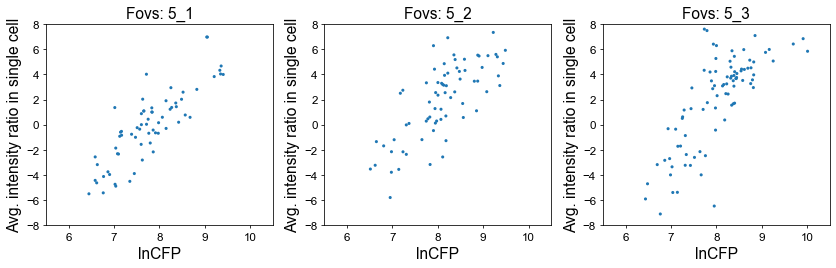

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

Fovs = sc_df['Fov'].unique()
# Set the number of columns (3 in this case)
n_cols = 8
n_rows = (len(Fovs) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create a figure and axes for the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(32, 4 * n_rows), dpi=70)

# Flatten the axes array for easy indexing if there are multiple rows
axes = axes.flatten()

# Loop through each No_Position pair and generate plots
for i, pos in enumerate(Fovs):
    temp_df = sc_df.loc[sc_df['Fov'] == pos].copy()

    # Select the current axis
    ax = axes[i]

    # Create a scatter plot on the current axis
    sns.scatterplot(
        data=temp_df,
        x='lnCFP',
        y='int_diff mean',
        #hue='position',
        edgecolor='none',
        #palette='viridis',
        s=10,
        ax=ax
    )

    ax.set_xlabel('lnCFP')
    ax.set_ylabel('Avg. intensity ratio in single cell')
    ax.set_xlim([5.5, 10.5])
    ax.set_ylim([-8, 8])

    # Set the title for the current plot
    ax.set_title(f'Fovs: {pos}')

# Hide any unused axes if the number of plots is not a multiple of 3
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make it tight
plt.tight_layout()
plt.show()

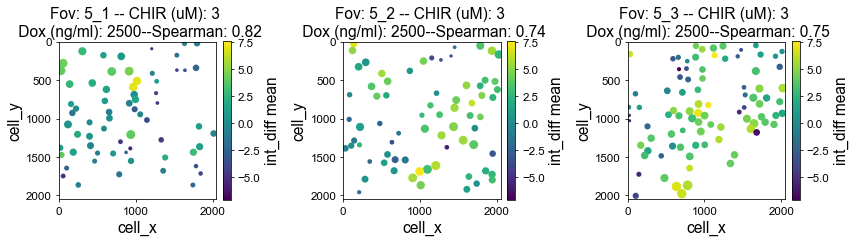

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm

Fovs = sc_df['Fov'].unique()

intmin = sub_df['int_diff mean'].min()
intmax = sub_df['int_diff mean'].max()
cfpmin = sub_df['lnCFP'].min()
cfpmax = sub_df['lnCFP'].max()

# Define the colormap
cmap = cm.get_cmap('viridis')

# Calculate the number of rows needed
num_plots = len(Fovs)
num_cols = 8
num_rows = int(np.ceil(num_plots / num_cols))

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(32, num_rows * 4), dpi=70)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Loop through each No_Position pair and generate plots
for i, pos in enumerate(Fovs):
    temp_df = sub_df.loc[sub_df['Fov'] == pos].copy()
    
    # Normalize the 'mout avg mean' values to control the size of the dots
    size_min = 10  # Minimum dot size
    size_max = 100  # Maximum dot size
    norm_size = (temp_df['lnCFP'] - cfpmin) / (cfpmax - cfpmin)
    sizes = size_min + norm_size * (size_max - size_min)
    
    # Calculate ranked correlation (Spearman's rho)
    if not temp_df['lnCFP'].empty and not temp_df['int_diff mean'].empty:
        correlation, _ = spearmanr(temp_df['lnCFP'], temp_df['int_diff mean'])
    else:
        correlation = float('nan')  # Handle empty data case
        
    # Create a scatter plot on the current axis
    scatter = axes[i].scatter(
        data=temp_df,
        x='cell_x',
        y='cell_y',
        c='int_diff mean',
        cmap=cmap,
        edgecolor='none',
        s=sizes,  # Dot size based on 'mout avg mean'
        vmin=intmin,
        vmax=intmax
    )
    
    cbar = plt.colorbar(scatter, ax=axes[i], fraction=0.046, pad=0.04, shrink=0.7)
    cbar.set_label('int_diff mean')
    
    axes[i].set_xlabel('cell_x')
    axes[i].set_ylabel('cell_y')
    axes[i].set_aspect('equal')
    # invert yaxis to set the origin [0,0] as the left top corner, which match to the coordinate system of cellpose exported DAPI mask
    axes[i].invert_yaxis()
    axes[i].set_ylim([2048, 0])
    axes[i].set_xlim([0, 2048])

    # Set plot title with correlation
    CHIR = temp_df['CHIR (uM)'].iloc[0]
    Dox = temp_df['Dox (ng/ml )'].iloc[0]
    axes[i].set_title(f'Fov: {pos} -- CHIR (uM): {CHIR} \n Dox (ng/ml): {Dox}--Spearman: {correlation:.2f}')

# Hide any unused axes if the number of plots is not a multiple of num_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout to make it tight
plt.tight_layout()
plt.show()